In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import tree
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [2]:
df = pd.read_csv("../processed.cleveland.data",sep=',')
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df.columns = column_names

df_no_missing = df.loc[(df['ca']!='?') & (df['thal']!='?')]

X = df_no_missing.drop('num',axis=1).copy()
y = df_no_missing['num'].copy()
y = y.apply(lambda x: 1 if x > 0 else 0)

X_encoded = pd.get_dummies(X,columns=['sex','cp','fbs','restecg','exang','slope','thal']).astype(float)
X_encoded.head()

,age,trestbps,chol,thalach,oldpeak,ca,sex_0.0,sex_1.0,cp_1.0,cp_2.0,...,restecg_1.0,restecg_2.0,exang_0.0,exang_1.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,67.0,160.0,286.0,108.0,1.5,3.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,67.0,120.0,229.0,129.0,2.6,2.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,37.0,130.0,250.0,187.0,3.5,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,41.0,130.0,204.0,172.0,1.4,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,56.0,120.0,236.0,178.0,0.8,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [3]:
from sklearn.preprocessing import StandardScaler

X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [4]:
from sklearn.ensemble import RandomForestClassifier

#my classifier
clf = RandomForestClassifier(min_samples_split=2,
                             random_state=42,
                             criterion = "gini", # {“gini”, “entropy”, “log_loss”}
                             max_features="sqrt" # {“sqrt”, “log2”, None}
                             )
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

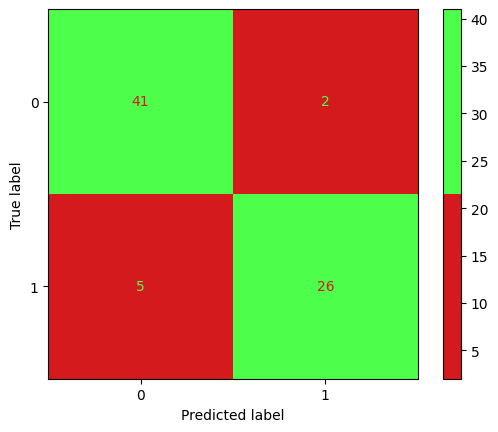

P-Value: 7.850455977702421e-13
Precision: 0.9286
Accuracy: 0.9054
Sensitivity (Recall): 0.8387


In [7]:
from scipy.stats import fisher_exact
from matplotlib import pyplot as plt
from matplotlib import colors
def plot_confusion_mat(ml_model,x_test1,y_test1):
    predictions = ml_model.predict(x_test1)
    cm = confusion_matrix(y_test1, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=colors.ListedColormap(['#d41a1c', '#4dff4a']))
    plt.show()

def print_metrics(ml_model,x_test1,y_test1):
    predictions = ml_model.predict(x_test1)
    observed = confusion_matrix(y_test1, predictions) #[[a, b], [c, d]] in fisher exact test => TP,FP,FN,TN

    _, p_value = fisher_exact(observed)
    precision = precision_score(y_test1, predictions)
    accuracy = accuracy_score(y_test1, predictions)
    sensitivity = recall_score(y_test1, predictions)

    print("P-Value:", p_value)
    print(f'Precision: {precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')

plot_confusion_mat(clf,X_test,y_test)
print_metrics(clf,X_test,y_test)

In [21]:
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

#Decision-Tree
decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=2,max_depth=2,min_samples_split=2)
decision_tree.fit(X_train,y_train)

#KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
kmeans.fit(X_train_scaled, y_train)

#Support-vector-machine
clf_svm = SVC(random_state = 42)
clf_svm.fit(X_train,y_train)

SVC(random_state=42)

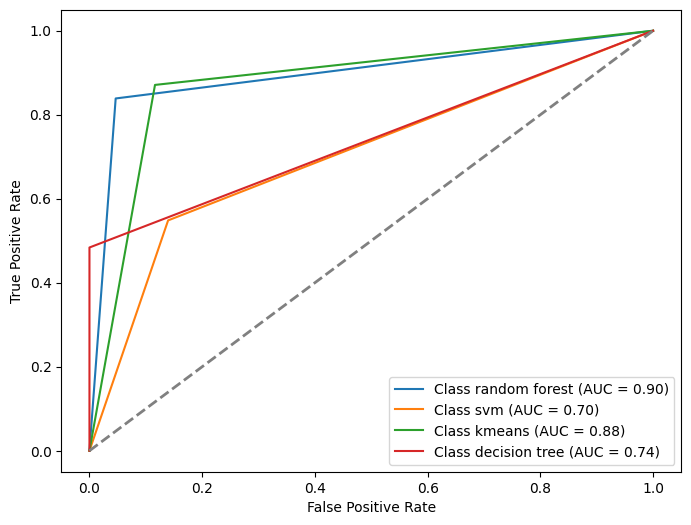

In [22]:
y_score_svm = clf_svm.predict(X_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

y_score_kmeans = kmeans.predict(X_test_scaled)
fpr_kmeans, tpr_kmeans, thresholds_kmeans = roc_curve(y_test, y_score_kmeans)
roc_auc_kmeans = auc(fpr_kmeans, tpr_kmeans)

y_score_dt = decision_tree.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

y_score_rf = clf.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))

plt.plot(fpr_rf, tpr_rf, label=f'Class random forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'Class svm (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_kmeans, tpr_kmeans, label=f'Class kmeans (AUC = {roc_auc_kmeans:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Class decision tree (AUC = {roc_auc_dt:.2f})')

# Plot a diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')

# Show the plot
plt.show()

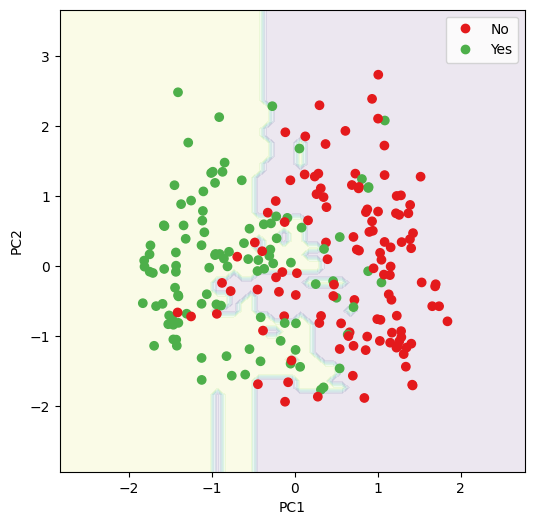

In [13]:
from sklearn.decomposition import PCA

pca= PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

pca_train_scaled = scaler.fit_transform(np.vstack((X_train_pca[:,0], X_train_pca[:,1])).T)

clf.fit(pca_train_scaled,y_train)

x_min = pca_train_scaled[:,0].min() - 1
x_max = pca_train_scaled[:,0].max() + 1

y_min = pca_train_scaled[:,1].min() - 1
y_max =pca_train_scaled[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
np.arange(start=y_min, stop=y_max, step=0.1))
Z = clf.predict(np.column_stack((xx.ravel(), yy.ravel( ))))
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(xx, yy, Z, alpha=0.1)

## now create custom colors for the actual data points
cmap = colors.ListedColormap( ['#e41a1c', '#4daf4a'])
scatter = ax.scatter(pca_train_scaled[:,0], pca_train_scaled[:,1], c=y_train,cmap=cmap)

## now create a legend
legend = ax. legend(scatter. legend_elements() [0],
scatter. legend_elements() [1],
loc="upper right")
legend.get_texts() [0].set_text("No")
legend.get_texts() [1].set_text("Yes")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# plt.savefig('svm_default.png')
plt.show()